In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyaccel as pa
import pymodels as pm
import pandas as pd
import time

# Functions

In [6]:
def plot_converge2eqparams(eqparams, part_out, ind=0, figtitle=None):
    sigmas = part_out.std(axis=1)
    sigmas_eq = np.array([eqparams.sigma_rx[ind],
                          eqparams.sigma_px[ind],
                          eqparams.sigma_ry[ind],
                          eqparams.sigma_py[ind],
                          eqparams.espread0,
                          eqparams.bunlen])
    sigmas_eq = np.nan_to_num(sigmas_eq)
#     print(sigmas_eq)
    ylabel_name = ['$\sigma_x \; [\mu m]$', '$\sigma_{px} \; [\mu rad]$',
                   '$\sigma_y \; [\mu m]$', '$\sigma_{py} \; [\mu rad]$',
                   '$\sigma_{\delta}$ [%]' , '$\sigma_{l} \; [\mu m]$']
    
    title_names = ['Horizontal size', 'Horizontal momentum',
                   'Vertical size','Vertical momentum',
                   'Energy spread', 'Bunch length']
    
    with plt.style.context(['notebook']):

        fig, ax = plt.subplots(2, 3)
        fax = ax.flat
        for i in range(6):
            m = 1e6 if (i!=4) else 1e2;
            fax[i].plot(sigmas[i]*m)
            fax[i].axhline(sigmas_eq[i]*m, c='k', label='Equilibrium')
            fax[i].set_ylabel(ylabel_name[i])
            fax[i].set_xlabel('Turns')
            fax[i].set_title(title_names[i])
#             fax[i].legend()
            
        fig.suptitle('Beam Phase Space Convergence @ QuantDiff on \n Initial condition: Closed Orbit')
        plt.tight_layout()
        if figtitle is not None:
            plt.savefig(figtitle, facecolor='white', transparent=False, dpi=300)
        plt.show()
        

def plot_nondiagonal_m(eq_env, part_out, ind=0, figtitle=None):
    
    turns = part_out.shape[-1]
    cov_evolution = np.zeros([part_out.shape[-1], 6, 6])

    for n in range(turns):
        actual_bunch = part_out[:, :, n]
        cov_evolution[n,:,:] = np.cov(actual_bunch)
    
    labels = ['x', 'px', 'y', 'py', '$\delta$', 'z']
    units = ['$(\mu m)^2$', '$(\mu m \cdot urad)$', '$(\mu m)$', '$(\mu rad)$']
    nd_m = np.triu(cov_evolution, 1)
    p_idx = 0
    
    with plt.style.context(['notebook']):
        fig, ax = plt.subplots(5, 3, figsize=(16,12))
        fax = ax.flat
        for i in range(6):
            for j in range(6):
                if nd_m[-1, i, j] != 0.:
                    if (i==0 or i==2 or i==5) and (j==0 or j==2 or j==5):
                        m = 1e12
                        unit = units[0]
                    if (j==0 or j==2 or j==5) and (i==0 or i==2 or i==5):
                        m = 1e12
                        unit = units[0]
                    if (i==0 or i==2 or i==5) and (j==1 or j==3):
                        m=1e12
                        unit = units[1]
                    if (j==0 or j==2 or j==5) and (i==1 or i==3):
                        m=1e12
                        unit = units[1]
                    if (i==0 or i==2 or i==5) and (j==4):
                        m=1e6
                        unit = units[2]
                    if (j==0 or j==2 or j==5) and (i==4):
                        m=1e6
                        unit = units[2]
                    if (i==1 or i==3) and (j==4):
                        m=1e6
                        unit = units[3]
                    if (i==j or j==3) and (i==4):
                        m=1e6
                        unit = units[3]
                    
                    dterms = np.sqrt(cov_evolution[:, i, i]*cov_evolution[:, j, j])
                    eqd_terms = np.sqrt(eq_env[i, i]*eq_env[j, j])
#                     fax[p_idx].plot(nd_m[:, i, j]*m/dterms)
#                     fax[p_idx].axhline(eq_env[i, j]*m, c='k')
                    n_turns = np.arange(nd_m.shape[0])/1e3
                    fax[p_idx].plot(n_turns, nd_m[:, i, j]/dterms)
                    fax[p_idx].axhline(eq_env[i, j]/eqd_terms, c='k')
                    coord = labels[i] + labels[j] #+ " " + unit
                    
                    fax[p_idx].set_ylabel('$R$'+coord)
                    fax[p_idx].set_xlabel(r'Turns [$10^3$]')
                    p_idx+=1
        
        fig.suptitle("Normalized variance of the nondiagonal terms", fontsize=16)
        plt.tight_layout()

        if figtitle is not None:
            plt.savefig(figtitle, facecolor='white', transparent=False, dpi=300)
        plt.show()
        
def compute_performance(accelerator, nturns = 500, nsamples=10):
    times = np.zeros(nsamples)
    for i in range(nsamples):
        t0 = time.clock()
        part_out, *_ = pa.tracking.ring_pass(accelerator=accelerator,
                                         particles=bunch,
                                         nr_turns=nturns, turn_by_turn=True, parallel=False)
        times[i] = time.clock() - t0
    return times.mean(), times.std()

# Performance tests

Accelerator equilibrium and optics params

In [7]:
acc = pm.si.create_accelerator()
acc.cavity_on=True
acc.vchamber_on = True
# acc.radiation_on = True

eqparams=pa.optics.EqParamsFromBeamEnvelope(acc)
twi, _ = pa.optics.calc_twiss(acc, indices=[0])
co = pa.tracking.find_orbit6(acc)
# Quantum diffusion only can be turned on after find C.O.
# acc.quantdiff_on = True

npart = 1
bunch = np.zeros([6, npart])
bunch[:, :] = co

In [8]:
# Without rad effects
acc.radiation_on='off'
print("Without rad effects:", compute_performance(acc))

# Only radiation damping
acc.radiation_on='damping'
print("With radiation damping:", compute_performance(acc))

# Damping and quantum diffusion (normal distribution)
pa.utils.set_distribution('normal')
acc.radiation_on='full'
print("With radiation damping + q. diffusion (normal):", compute_performance(acc))

# Damping and quantum diffusion (uniform distribution)
pa.utils.set_distribution('uniform')
acc.radiation_on='full'
print("With radiation damping + q. diffusion (uniform):", compute_performance(acc))

Without rad effects: (0.806279, 0.056952435115629516)
With radiation damping: (1.1220388000000008, 0.06893794184308125)
With radiation damping + q. diffusion (normal): (1.8015601, 0.0681978855279968)
With radiation damping + q. diffusion (uniform): (1.6164926999999991, 0.0460980828517853)


# Initial condition: Putting all particles in the closed orbit


In [3]:
npart = 200
bunch = np.zeros([6, npart])
bunch[:, :] = co

In [4]:
nturns = 500
part_out, *_ = pa.tracking.ring_pass(accelerator=acc,
                                     particles=bunch,
                                     nr_turns=nturns, turn_by_turn=True, parallel=True)
np.save('slower_version.npy', part_out)

In [5]:
slower = np.load('slower_version.npy')
faster = np.load('fast_version.npy')

In [6]:
np.allclose(slower, faster)

True

Lets run for more 10000 turns

In [27]:
middle_bunch = part_out[:,:,-1]

nturns = 10000
part_out2, *_ = pa.tracking.ring_pass(accelerator=acc,
                                     particles=middle_bunch,
                                     nr_turns=nturns, turn_by_turn=True, parallel=True)
part_out_final = np.concatenate((part_out, part_out2), axis=2)

In [34]:
np.save('qdiff_ic1_fulltracking',part_out_final)

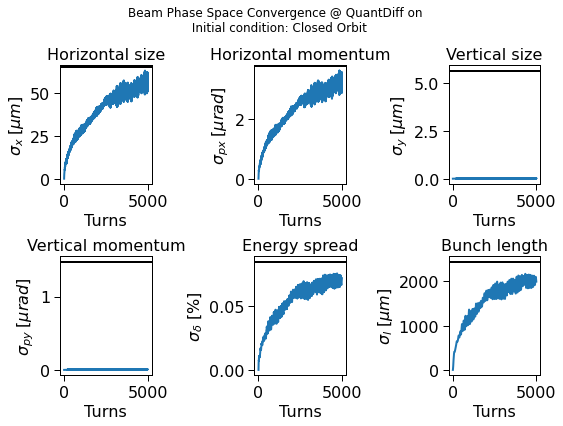

In [48]:
plot_converge2eqparams(eqparams, part_out, 0, 'convergence_from_co.png')

## Fitting excitation parameter and damping time

Using the results to fit $Q_x$ and $\tau_x$ by the analytical expression:

\begin{equation}
\frac{d(\sigma_x^2)}{dN} = (\frac{Q_x\beta_x}{2} - \frac{2\sigma_x^2}{\tau_x}) T_R
\end{equation}

In [28]:
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

In [49]:
part_out = np.load('qdiff_ic1_no_coupling.npy')

In [50]:
sigmax_data=part_out[0,:,:].std(axis=0)

Creating a ODE integrator 

In [51]:
Tr = 1/(0.5783*1e6)
beta1 = twi.betax[0]

def dsigmax2(N, sigmax2, qx, taux):
    return (qx*beta1/2 - 2*sigmax2/taux)*Tr

def sigmax2_sol(N, qx, taux):
    sol = solve_ivp(fun=dsigmax2, t_span=[0, 5001], y0=[0], dense_output=True, args=(qx, taux))
    return sol.sol(N)[0, :]

Fitting the params $Q_x$ and $\tau_x$

In [52]:
taux0 = 0.017
qx0 = taux0/3
N_span = np.arange(5001)

In [58]:
popt, pcov = curve_fit(sigmax2_sol, N_span, sigmax_data**2, p0 = [qx0, taux0])

In [59]:
uncert = np.diag(np.sqrt(pcov))

/home/jucelio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


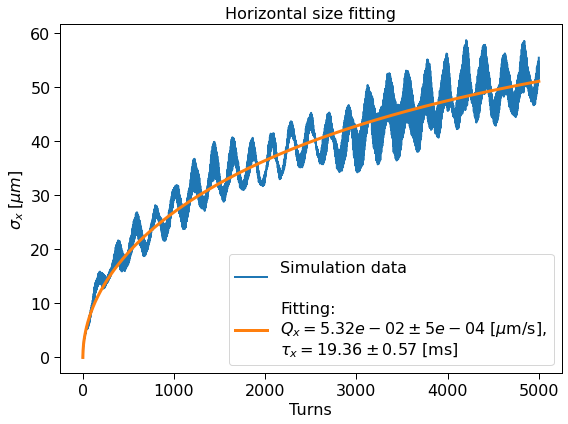

In [60]:
with plt.style.context(['notebook']):
    plt.plot(sigmax_data*1e6, label='Simulation data\n')
    plt.plot(
        np.sqrt(sigmax2_sol(N_span, *popt))*1e6, lw=3,
        label='Fitting:\n'
        rf'$Q_x = {popt[0]*1e6:.2e} \pm {uncert[0]*1e6:.0e}$ [$\mu$m/s],'
        '\n'
        rf'$\tau_x = {popt[1]*1e3:.2f} \pm {uncert[1]*1e3:.2f}$ [ms]')
    plt.title('Horizontal size fitting')
    plt.legend()
    plt.xlabel('Turns')
    plt.ylabel(r'$\sigma_x \; [\mu m]$')
    plt.tight_layout()
    plt.savefig('figures/sigmax_fitting.png', facecolor='white', transparent=False, dpi=300)

Computing $Q_x$ from the formula:

\begin{equation}
Q_x = \frac{4\sigma_x^2}{\tau_x \beta_x}|_{equilibrium}
\end{equation}

In [63]:
acc.quantdiff_on = False
eqparams = pa.optics.EqParamsFromBeamEnvelope(acc)

In [67]:
Qx = 4*eqparams.sigma_rx[0]**2/(eqparams.tau1 * beta1)

In [69]:
Qx, eqparams.tau1

(5.7855492980452365e-08, 0.01684617539794362)

Now, lets to fit the damping in the energy and the coefficient of energy loss

\begin{equation}
\frac{d(\sigma_{\delta}^2)}{dN} = (\frac{Q_{\epsilon}}{2 E_0^2} - \frac{2\sigma_{\delta}^2}{\tau_\epsilon}) T_R
\end{equation}

In [70]:
Tr = 1/(0.5783*1e6)
E0 = acc.energy

def dsigma_delta2(N, sigmae2, qe, taue):
    return (qe/(2*E0**2) - 2*sigmae2/taue)*Tr

def sigma_delta2_sol(N, qe, taue):
    sol = solve_ivp(fun=dsigma_delta2, t_span=[0, 5e3+1], y0=[0], dense_output=True, args=(qe, taue))
    return sol.sol(N)[0, :]

In [71]:
sigmae_data=part_out[4,:,:].std(axis=0)
taue0 = 0.017
qe0 = 0.433333e15
N_span = np.arange(5001)
popt, pcov = curve_fit(
    sigma_delta2_sol, N_span, sigmae_data**2, p0 = [qe0, taue0])
uncert = np.diag(np.sqrt(pcov))

/home/jucelio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


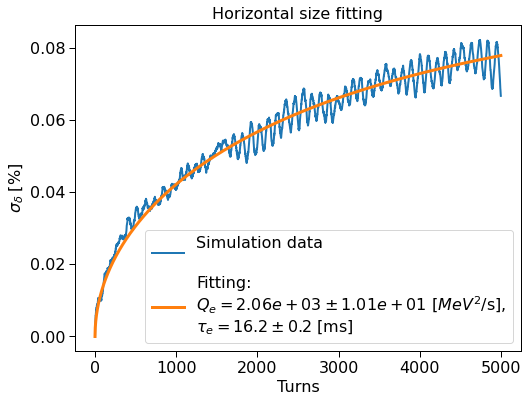

In [72]:
with plt.style.context(['notebook']):

    plt.plot(sigmae_data*1e2, label='Simulation data\n')
    plt.plot(
        np.sqrt(sigma_delta2_sol(N_span, *popt))*1e2, lw=3,
        label='Fitting:\n'
            rf'$Q_e = {1e-12*popt[0]:.2e} \pm {1e-12*uncert[0]:.2e}$ [$MeV^2$/s],'
            '\n'
            rf'$\tau_e = {popt[1]*1e3:.1f} \pm {uncert[1]*1e3:.1f}$ [ms]')

    #     label=rf'Fit, $Q_e = {1e-12*popt[0]:.2e} \pm {uncert[0]:.2e}$, $\tau_e = {popt[1]:.2e} \pm {uncert[0]:.2e}$')
    plt.title('Horizontal size fitting')
    plt.legend()
#     plt.tight_layout()
    plt.xlabel('Turns')
    plt.ylabel(r'$\sigma_{\delta} \; [\%]$')
    plt.savefig('figures/sigmae_fitting.png', facecolor='white', transparent=False, dpi=300)

In [ ]:
uncert

Computing $Q_e$ from the formula:

\begin{equation}
Q_e = 4\frac{\sigma_{\delta}^2 E_0^2}{\tau_e}|_{equilibrium}
\end{equation}

In [ ]:
Qe = 4*eqparams_rad.espread0**2*acc.energy**2/(eqparams_rad.taue)

In [ ]:
Qe/1e15, eqparams_rad.taue

In [ ]:
eqparams.tau3

# Initial condition: the same as before but with coupling

In [18]:
fmod = pm.si.create_accelerator()
famdata = pm.si.get_family_data(fmod)
fmod = pm.si.fitted_models.vertical_dispersion_and_coupling(fmod, famdata)
fmod.cavity_on=True
fmod.vchamber_on = True
fmod.radiation_on = 'full'

eqparams=pa.optics.EqParamsFromBeamEnvelope(fmod)
eteng, _ = pa.optics.calc_edwards_teng(fmod)
co = pa.tracking.find_orbit6(fmod)
# Quantum diffusion only can be turned on after find C.O.

In [6]:
c, emit_ratio = pa.optics.estimate_coupling_parameters(eteng)

In [7]:
npart = 2**11
bunch = np.zeros([6, npart])
bunch[:, :] = co

In [8]:
nturns = 25000
part_out, *_ = pa.tracking.ring_pass(accelerator=fmod,
                                     particles=bunch,
                                     nr_turns=nturns, turn_by_turn=True, parallel=True)

np.save("data/qdiff_ic1_w_coupling_fulltracking_uniform_dist.npy", part_out)

In [11]:
part_out = np.load("data/qdiff_ic1_w_coupling_fulltracking_uniform_dist.npy")

/home/facs/repos/pyaccel/pyaccel/optics/beam_envelope.py:278: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt(self._envelope[:, 0, 0])
/home/facs/repos/pyaccel/pyaccel/optics/beam_envelope.py:283: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt(self._envelope[:, 1, 1])
/home/facs/repos/pyaccel/pyaccel/optics/beam_envelope.py:288: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt(self._envelope[:, 2, 2])
/home/facs/repos/pyaccel/pyaccel/optics/beam_envelope.py:293: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt(self._envelope[:, 3, 3])


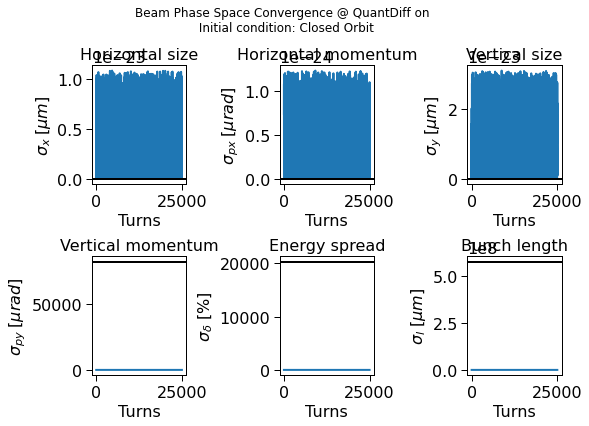

In [9]:
plot_converge2eqparams(eqparams, part_out, figtitle='figures/tracking_w_coupling2_newimplement.png')

In [15]:
eq_env = pa.optics.calc_beamenvelope(fmod, indices=[0])[0]
fenv = np.cov(part_out[:,:, -1])
labels=["x", "x'", "y", "y'", "$\delta$", "z"]

Lets see the convergence of discrepant terms

In [17]:
turns = part_out.shape[-1]
cov_evolution = np.zeros([6, 6, part_out.shape[-1]])

for n in range(turns):
    actual_bunch = part_out[:, :, n]
    cov_evolution[:,:,n] = np.cov(actual_bunch)

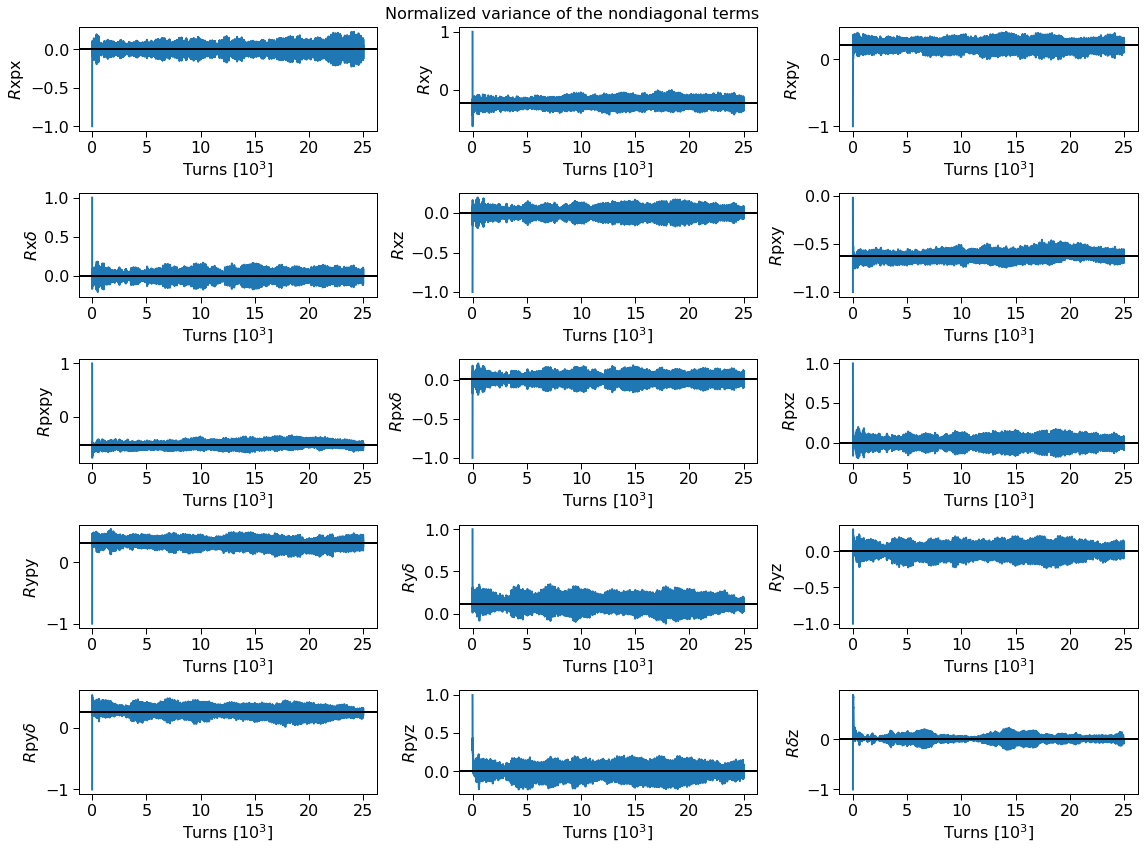

In [18]:
plot_nondiagonal_m(eq_env, part_out, figtitle='non_diagonal.png')

# Simulating the beam size convergence from other initial condition

In [20]:
fmod.radiation_on = 'full'

In [21]:
emit1 = eqparams.emit1
emit2 = eqparams.emit2
sigmae = eqparams.espread0
sigmas = eqparams.bunlen

In [22]:
bunch = pa.tracking.generate_bunch(
    emit1=emit1, emit2=0, sigmae=sigmae,
    sigmas=sigmas, optics=eteng[0], n_part=500)

In [23]:
nturns=1000
part_out_rad, *_ = pa.tracking.ring_pass(accelerator=fmod,
                      particles=bunch, nr_turns=nturns,
                      turn_by_turn=True, parallel=True)

In [24]:
sigmasx = part_out_rad[0].std(axis=0)
sigmasy = part_out_rad[2].std(axis=0)

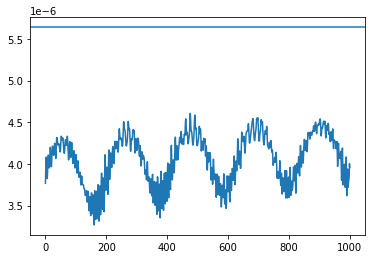

In [28]:
plt.plot(sigmasy)
plt.axhline(eqparams.sigma_ry[0])

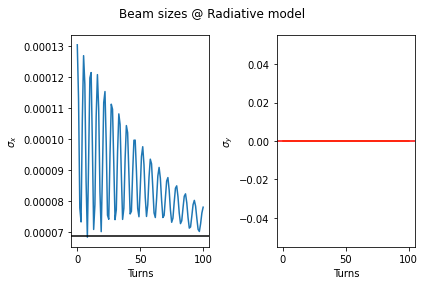

In [12]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(sigmasx)
ax[0].axhline(sigma1, c='k')
ax[1].plot(sigmasy, c='tab:orange')
ax[1].axhline(sigma2, c='r')

ax[0].set_ylabel("$\sigma_x$")
ax[1].set_ylabel("$\sigma_y$")
ax[0].set_xlabel("Turns")
ax[1].set_xlabel("Turns")

fig.suptitle('Beam sizes @ Radiative model')
plt.tight_layout()
plt.show()